# Approximating data using deep learning

Note that for this approach we based ourselves on the Standford lecture notes on convolutional neural networks for visual recognition.

This lecture is open source and can be found on http://cs231n.github.io/ 

In [23]:
# Clean up the memory
%reset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%load_ext autoreload
%autoreload 2

import gc

import crowd
import experts
import supercrowd as sc

import numpy as np
import math
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = "data/"
SESSION_FOLDER = "session/"

TRAIN_SET_PERC = 0.75

In [3]:
def rmse(pred, real, loop = True):
    '''
    Computes RMSE between predictions and real values
    :param : float[]
    :param : float[]
    :return : float
    '''
    if len(pred) != len(real):
        print("RMSE Error : Predictions and real values arrays do not have the same length, aborting.")
        return None
    
    if loop:
        mse = 0
        for i in range(len(pred)):
            mse += (pred[i] - real[i])**2
        return math.sqrt(mse/len(pred))
    else:
        # The creation of the array may produce memory error
        err = pred - real
        mse = err.T @ err
        return math.sqrt(2 * mse / len(pred))
    
    
def basic_error(pred, real):
    '''
    Compute basic error. Used to notify bias.
    :param : float[]
    :param : float[]
    :return : float
    '''
    err = 0
    for i in range(len(pred)):
        err += (pred[i][0][0] - real[i])
    return err
    
    
def build_poly(X, degree):
    poly = np.ones((len(X), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(X, deg)]
    return poly[:, 1:]

def garbage_collection():
    '''
    Calls garbage collection to clean unused memory
    '''
    gc.collect()

In [4]:
def plot_history(history):
    '''
    Plots the history of the training error
    Usefull 
    '''
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])

## Preparing the data



In [6]:
# Use non normalized feature matrix
# For now best results are given with this one
#X = np.load(DATA_FOLDER + "feature_mat_radial_compression.npy")

# Use normalized feature matrix
################################################################################################
# Careful                                                                                      #
# Normally, normalisation should be done one each train/val/test matrices. It is not done here #
################################################################################################
X = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

In [11]:
# Prepare train and test set

train_set_size = int(len(X) * TRAIN_SET_PERC)
X_train = X[: train_set_size]
X_test = X[train_set_size:]
y_train = y[: train_set_size]
y_test = y[train_set_size :]

In [12]:
print("X: " + str(X.shape))
print("y: " + str(y.shape))

X: (30049, 15961)
y: (30049,)


# Single neural network model approach

First we will do a single model approach, the goal is to see quickly how we can build a model using neural networks and how well it does. 

In [14]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Number of layers and neurons doesn't really matter, we need as much as possible.
    # We well take care of overfitting with regularizers.
    # We chose relu activation (relative usual choice when working on regression)
    # We add L2 regularizers on hidden layers to avoid overfitting the data. Threshold should be tuned.
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

In [15]:
# We train the model on our data
# Number of epochs the network should run through
EPOCHS = 200
# Size of the batch for optimization
BATCH_SIZE = 32
# Set up validation split
VALIDATION_SPLIT = 0.1
# The patience parameter is the amount of epochs to check for improvement
# This will avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

Train on 24339 samples, validate on 2705 samples
Epoch 1/200
24339/24339 [==============================] - 33s 1ms/step - loss: 16.2263 - mean_absolute_error: 2.3938 - val_loss: 6.2262 - val_mean_absolute_error: 1.8358
Epoch 2/200
24339/24339 [==============================] - 33s 1ms/step - loss: 3.2662 - mean_absolute_error: 1.3039 - val_loss: 4.0006 - val_mean_absolute_error: 1.4015
Epoch 3/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.8035 - mean_absolute_error: 0.9428 - val_loss: 4.2133 - val_mean_absolute_error: 1.4561
Epoch 4/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.7472 - mean_absolute_error: 0.9308 - val_loss: 3.5445 - val_mean_absolute_error: 1.3147
Epoch 5/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.4083 - mean_absolute_error: 0.8200 - val_loss: 3.1718 - val_mean_absolute_error: 1.2550
Epoch 6/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.9822 - mean_absolu

Epoch 49/200
24339/24339 [==============================] - 33s 1ms/step - loss: 0.2332 - mean_absolute_error: 0.2662 - val_loss: 0.6181 - val_mean_absolute_error: 0.5156
Epoch 50/200
24339/24339 [==============================] - 32s 1ms/step - loss: 0.2462 - mean_absolute_error: 0.2666 - val_loss: 0.5834 - val_mean_absolute_error: 0.4958
Epoch 51/200
24339/24339 [==============================] - 34s 1ms/step - loss: 0.2626 - mean_absolute_error: 0.2700 - val_loss: 0.6383 - val_mean_absolute_error: 0.5298
Epoch 52/200
24339/24339 [==============================] - 35s 1ms/step - loss: 0.2387 - mean_absolute_error: 0.2609 - val_loss: 0.6260 - val_mean_absolute_error: 0.5193
Epoch 53/200
24339/24339 [==============================] - 33s 1ms/step - loss: 0.2534 - mean_absolute_error: 0.2679 - val_loss: 0.7373 - val_mean_absolute_error: 0.5672
Epoch 54/200
24339/24339 [==============================] - 30s 1ms/step - loss: 0.2392 - mean_absolute_error: 0.2541 - val_loss: 0.6180 - val_me

Epoch 97/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1789 - mean_absolute_error: 0.2405 - val_loss: 0.6396 - val_mean_absolute_error: 0.5494
Epoch 98/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1754 - mean_absolute_error: 0.2384 - val_loss: 0.5826 - val_mean_absolute_error: 0.5109
Epoch 99/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1846 - mean_absolute_error: 0.2464 - val_loss: 0.6068 - val_mean_absolute_error: 0.5251
Epoch 100/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1732 - mean_absolute_error: 0.2346 - val_loss: 0.5752 - val_mean_absolute_error: 0.4983
Epoch 101/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1945 - mean_absolute_error: 0.2554 - val_loss: 0.5877 - val_mean_absolute_error: 0.5083
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dens

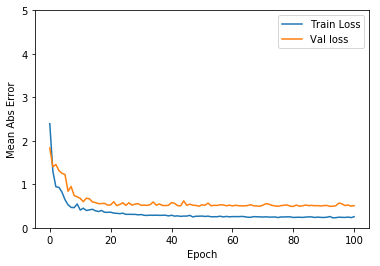

In [16]:
plot_history(history)

In [17]:
result = model.predict(X_test, batch_size=32)
rmse(result, y_test)

0.6604633181447641

## Results

For the following model :
    - 4 hidden layers of 64 neurons - relu activation.
    - A result layer of 1 neuron - relu activation.
    - Early stopping callback
    - Test split of 0.2
    - Using AdamOptimizer gives best results.
    - No cross validation.
    
Network size :
- $4*64 + 1 = 257$ neurons (biases)
- $30049*64 + 64*64 + 64*64 + 64 = 1931392$ weights
- Total of $1931649$ learnable parameters (almost 2 millions)

With the above, we reached a RMSE of 0.5. But this is without separating the data into train and test set. This can lead to overfitting. Now we need to ensure that we are not overfitting.

For this we will test 2 solutions :

### Change our implementation to add regulizer that will avoid this overfitting

### Cross validation over multiple models

# Multi neural network approach

In [5]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")
X_red.shape

(30049, 3004)

In [6]:
train_set_size = int(len(X_red) * TRAIN_SET_PERC)

# Select random rows of the matrix for train / test set
# Random seed for reproducibility 
np.random.seed(100)
train_idx = np.random.choice(len(X_red), size=train_set_size, replace = False)
test_idx = [i for i in range(len(X_red)) if i not in train_idx]
X_train_red = X_red[train_idx, :]
X_test_red = X_red[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]

In [7]:
print("X_red: " + str(X_red.shape))
print("y: " + str(y.shape))

X_red: (30049, 3004)
y: (30049,)


In [8]:
crowd01 = crowd.Crowd(X_train_red, y_train, "DNN_Crowd")
crowd01.restore()

Recovered 24 entities from session/DNN_Crowd_8_128_relu_0.01_0.001_mse/24


In [9]:
crowd01.train_new_entities(8)

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20000/20282 [============================>.] - ETA: 0s - loss: 31.7270 - mean_absolute_error: 3.0263
Epoch 00001: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 207us/step - loss: 31.4746 - mean_absolute_error: 3.0093 - val_loss: 13.8795 - val_mean_absolute_error: 1.7699
Epoch 2/200
20128/20282 [============================>.] - ETA: 0s - loss: 11.9335 - mean_absolute_error: 1.5997
Epoch 00002: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 177us/step - loss: 11.9072 - mean_absolute_error: 1.5954 - val_loss: 9.6185 - val_mean_absolute_error: 1.2785
Epoch 3/200
20224/20282 [============================>.] - ETA: 0s - loss: 7.7107 - mean_absolute_error: 0.9397
Epoch 00003: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 194us/step - l

20282/20282 [==============================] - 4s 178us/step - loss: 0.7459 - mean_absolute_error: 0.4270 - val_loss: 0.8983 - val_mean_absolute_error: 0.4864
Epoch 25/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7864 - mean_absolute_error: 0.4519
Epoch 00025: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 173us/step - loss: 0.7863 - mean_absolute_error: 0.4520 - val_loss: 1.1304 - val_mean_absolute_error: 0.6567
Epoch 26/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.7316 - mean_absolute_error: 0.4306
Epoch 00026: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 173us/step - loss: 0.7310 - mean_absolute_error: 0.4304 - val_loss: 0.8046 - val_mean_absolute_error: 0.4729
Epoch 27/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6920 - mean_absolute_error: 0.4228
Epoch 00027: saving model to ses

Epoch 72/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5434 - mean_absolute_error: 0.3968
Epoch 00072: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 187us/step - loss: 0.5447 - mean_absolute_error: 0.3974 - val_loss: 0.6299 - val_mean_absolute_error: 0.4292
Epoch 73/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5067 - mean_absolute_error: 0.3729
Epoch 00073: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 184us/step - loss: 0.5068 - mean_absolute_error: 0.3730 - val_loss: 0.5901 - val_mean_absolute_error: 0.4114
Epoch 74/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5332 - mean_absolute_error: 0.3897
Epoch 00074: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 178us/step - loss: 0.5340 - mean_absolute_error: 0.3905 - val_los

Epoch 3/200
20096/20282 [============================>.] - ETA: 0s - loss: 7.0411 - mean_absolute_error: 0.7867
Epoch 00003: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 191us/step - loss: 7.0323 - mean_absolute_error: 0.7858 - val_loss: 6.2038 - val_mean_absolute_error: 0.7172
Epoch 4/200
20160/20282 [============================>.] - ETA: 0s - loss: 5.2288 - mean_absolute_error: 0.5395
Epoch 00004: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 181us/step - loss: 5.2246 - mean_absolute_error: 0.5390 - val_loss: 4.8803 - val_mean_absolute_error: 0.6048
Epoch 5/200
20096/20282 [============================>.] - ETA: 0s - loss: 4.2745 - mean_absolute_error: 0.5611
Epoch 00005: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 189us/step - loss: 4.2708 - mean_absolute_error: 0.5609 - val_loss: 

Epoch 27/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6969 - mean_absolute_error: 0.4269
Epoch 00027: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 188us/step - loss: 0.6968 - mean_absolute_error: 0.4268 - val_loss: 0.8671 - val_mean_absolute_error: 0.5058
Epoch 28/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6758 - mean_absolute_error: 0.4204
Epoch 00028: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 185us/step - loss: 0.6760 - mean_absolute_error: 0.4205 - val_loss: 0.8145 - val_mean_absolute_error: 0.4754
Epoch 29/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6698 - mean_absolute_error: 0.4190
Epoch 00029: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 183us/step - loss: 0.6697 - mean_absolute_error: 0.4190 - val_los

Epoch 51/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5518 - mean_absolute_error: 0.3998
Epoch 00051: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 185us/step - loss: 0.5516 - mean_absolute_error: 0.3997 - val_loss: 0.7422 - val_mean_absolute_error: 0.4946
Epoch 52/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5420 - mean_absolute_error: 0.3926
Epoch 00052: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 184us/step - loss: 0.5430 - mean_absolute_error: 0.3933 - val_loss: 0.6439 - val_mean_absolute_error: 0.4341
Epoch 53/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.5442 - mean_absolute_error: 0.3924
Epoch 00053: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 186us/step - loss: 0.5444 - mean_absolute_error: 0.3924 - val_los

20282/20282 [==============================] - 4s 184us/step - loss: 0.5088 - mean_absolute_error: 0.3796 - val_loss: 0.6480 - val_mean_absolute_error: 0.4409
Epoch 75/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5166 - mean_absolute_error: 0.3812
Epoch 00075: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 193us/step - loss: 0.5173 - mean_absolute_error: 0.3814 - val_loss: 0.7498 - val_mean_absolute_error: 0.5118
Epoch 76/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5129 - mean_absolute_error: 0.3817
Epoch 00076: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 185us/step - loss: 0.5134 - mean_absolute_error: 0.3822 - val_loss: 0.6565 - val_mean_absolute_error: 0.4688
Epoch 77/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5074 - mean_absolute_error: 0.3798
Epoch 00077: saving model to ses

Epoch 7/200
20256/20282 [============================>.] - ETA: 0s - loss: 3.1032 - mean_absolute_error: 0.5447
Epoch 00007: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 4s 178us/step - loss: 3.1028 - mean_absolute_error: 0.5448 - val_loss: 2.8670 - val_mean_absolute_error: 0.5482
Epoch 8/200
19968/20282 [============================>.] - ETA: 0s - loss: 2.5636 - mean_absolute_error: 0.5330
Epoch 00008: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 3s 165us/step - loss: 2.5587 - mean_absolute_error: 0.5324 - val_loss: 2.5098 - val_mean_absolute_error: 0.5752
Epoch 9/200
20032/20282 [============================>.] - ETA: 0s - loss: 2.0976 - mean_absolute_error: 0.5020
Epoch 00009: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 3s 172us/step - loss: 2.0961 - mean_absolute_error: 0.5023 - val_loss: 

Epoch 31/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6516 - mean_absolute_error: 0.4081
Epoch 00031: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 4s 179us/step - loss: 0.6518 - mean_absolute_error: 0.4084 - val_loss: 0.7624 - val_mean_absolute_error: 0.4727
Epoch 32/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6170 - mean_absolute_error: 0.4058
Epoch 00032: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 4s 196us/step - loss: 0.6165 - mean_absolute_error: 0.4055 - val_loss: 0.7404 - val_mean_absolute_error: 0.4425
Epoch 33/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6297 - mean_absolute_error: 0.4039
Epoch 00033: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 4s 195us/step - loss: 0.6294 - mean_absolute_error: 0.4037 - val_los

20282/20282 [==============================] - 4s 181us/step - loss: 0.5472 - mean_absolute_error: 0.3871 - val_loss: 0.6682 - val_mean_absolute_error: 0.4368
Epoch 55/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.5728 - mean_absolute_error: 0.4049
Epoch 00055: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 4s 173us/step - loss: 0.5747 - mean_absolute_error: 0.4057 - val_loss: 0.6749 - val_mean_absolute_error: 0.4523
Epoch 56/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5425 - mean_absolute_error: 0.3827
Epoch 00056: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 4s 175us/step - loss: 0.5431 - mean_absolute_error: 0.3828 - val_loss: 0.6933 - val_mean_absolute_error: 0.4409
Epoch 57/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.5651 - mean_absolute_error: 0.3929
Epoch 00057: saving model to ses

Epoch 21/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.8839 - mean_absolute_error: 0.4585
Epoch 00021: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 184us/step - loss: 0.8838 - mean_absolute_error: 0.4584 - val_loss: 0.9874 - val_mean_absolute_error: 0.4996
Epoch 22/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.8199 - mean_absolute_error: 0.4462
Epoch 00022: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 175us/step - loss: 0.8204 - mean_absolute_error: 0.4467 - val_loss: 0.9048 - val_mean_absolute_error: 0.4841
Epoch 23/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.8105 - mean_absolute_error: 0.4368
Epoch 00023: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 173us/step - loss: 0.8114 - mean_absolute_error: 0.4368 - val_los

Epoch 45/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.5873 - mean_absolute_error: 0.4081
Epoch 00045: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 186us/step - loss: 0.5872 - mean_absolute_error: 0.4083 - val_loss: 0.6572 - val_mean_absolute_error: 0.4301
Epoch 46/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5338 - mean_absolute_error: 0.3804
Epoch 00046: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 182us/step - loss: 0.5345 - mean_absolute_error: 0.3806 - val_loss: 0.7162 - val_mean_absolute_error: 0.4925
Epoch 47/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5481 - mean_absolute_error: 0.3885
Epoch 00047: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 183us/step - loss: 0.5491 - mean_absolute_error: 0.3894 - val_los

Epoch 69/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5057 - mean_absolute_error: 0.3748
Epoch 00069: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 177us/step - loss: 0.5058 - mean_absolute_error: 0.3745 - val_loss: 0.6108 - val_mean_absolute_error: 0.4190
Epoch 70/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5113 - mean_absolute_error: 0.3817
Epoch 00070: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 176us/step - loss: 0.5117 - mean_absolute_error: 0.3821 - val_loss: 0.5986 - val_mean_absolute_error: 0.4220
Epoch 71/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5082 - mean_absolute_error: 0.3771
Epoch 00071: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 177us/step - loss: 0.5084 - mean_absolute_error: 0.3772 - val_los

Epoch 3/200
20064/20282 [============================>.] - ETA: 0s - loss: 1.2102 - mean_absolute_error: 0.4211
Epoch 00003: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 180us/step - loss: 1.2103 - mean_absolute_error: 0.4217 - val_loss: 1.2627 - val_mean_absolute_error: 0.4913
Epoch 4/200
20224/20282 [============================>.] - ETA: 0s - loss: 1.0502 - mean_absolute_error: 0.4049
Epoch 00004: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 178us/step - loss: 1.0498 - mean_absolute_error: 0.4049 - val_loss: 1.2416 - val_mean_absolute_error: 0.5576
Epoch 5/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.9603 - mean_absolute_error: 0.4278
Epoch 00005: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 180us/step - loss: 0.9616 - mean_absolute_error: 0.4285 - val_loss: 

Epoch 27/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6993 - mean_absolute_error: 0.4403
Epoch 00027: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 175us/step - loss: 0.7001 - mean_absolute_error: 0.4407 - val_loss: 0.7698 - val_mean_absolute_error: 0.4697
Epoch 28/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6537 - mean_absolute_error: 0.4204
Epoch 00028: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 180us/step - loss: 0.6537 - mean_absolute_error: 0.4206 - val_loss: 0.8463 - val_mean_absolute_error: 0.5281
Epoch 29/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6757 - mean_absolute_error: 0.4218
Epoch 00029: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 178us/step - loss: 0.6755 - mean_absolute_error: 0.4217 - val_los

Epoch 51/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5647 - mean_absolute_error: 0.4021
Epoch 00051: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 202us/step - loss: 0.5643 - mean_absolute_error: 0.4017 - val_loss: 0.6555 - val_mean_absolute_error: 0.4351
Epoch 52/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5865 - mean_absolute_error: 0.4157
Epoch 00052: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 184us/step - loss: 0.5862 - mean_absolute_error: 0.4155 - val_loss: 0.6463 - val_mean_absolute_error: 0.4245
Epoch 53/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5630 - mean_absolute_error: 0.3978
Epoch 00053: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 197us/step - loss: 0.5634 - mean_absolute_error: 0.3981 - val_los

Epoch 3/200
20096/20282 [============================>.] - ETA: 0s - loss: 7.8518 - mean_absolute_error: 0.9009
Epoch 00003: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 200us/step - loss: 7.8380 - mean_absolute_error: 0.8988 - val_loss: 6.6000 - val_mean_absolute_error: 0.7427
Epoch 4/200
20256/20282 [============================>.] - ETA: 0s - loss: 5.5940 - mean_absolute_error: 0.5602
Epoch 00004: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 194us/step - loss: 5.5931 - mean_absolute_error: 0.5601 - val_loss: 5.2421 - val_mean_absolute_error: 0.6172
Epoch 5/200
20192/20282 [============================>.] - ETA: 0s - loss: 4.5227 - mean_absolute_error: 0.5306
Epoch 00005: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 213us/step - loss: 4.5210 - mean_absolute_error: 0.5307 - val_loss: 

Epoch 27/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.7616 - mean_absolute_error: 0.4387
Epoch 00027: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 191us/step - loss: 0.7611 - mean_absolute_error: 0.4384 - val_loss: 0.8532 - val_mean_absolute_error: 0.4718
Epoch 28/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.7006 - mean_absolute_error: 0.4100
Epoch 00028: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 182us/step - loss: 0.7002 - mean_absolute_error: 0.4098 - val_loss: 0.8481 - val_mean_absolute_error: 0.5012
Epoch 29/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.7092 - mean_absolute_error: 0.4332
Epoch 00029: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 203us/step - loss: 0.7091 - mean_absolute_error: 0.4331 - val_los

Epoch 51/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5552 - mean_absolute_error: 0.3934
Epoch 00051: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 181us/step - loss: 0.5551 - mean_absolute_error: 0.3933 - val_loss: 0.6331 - val_mean_absolute_error: 0.4244
Epoch 52/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5493 - mean_absolute_error: 0.3916
Epoch 00052: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 181us/step - loss: 0.5494 - mean_absolute_error: 0.3916 - val_loss: 0.6651 - val_mean_absolute_error: 0.4310
Epoch 53/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5362 - mean_absolute_error: 0.3866
Epoch 00053: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 181us/step - loss: 0.5367 - mean_absolute_error: 0.3868 - val_los

Epoch 75/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5251 - mean_absolute_error: 0.3887
Epoch 00075: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 185us/step - loss: 0.5253 - mean_absolute_error: 0.3888 - val_loss: 0.6600 - val_mean_absolute_error: 0.4667
Epoch 76/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.5039 - mean_absolute_error: 0.3789
Epoch 00076: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 190us/step - loss: 0.5042 - mean_absolute_error: 0.3789 - val_loss: 0.6585 - val_mean_absolute_error: 0.4562
Epoch 77/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5006 - mean_absolute_error: 0.3725
Epoch 00077: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 187us/step - loss: 0.5001 - mean_absolute_error: 0.3721 - val_los

Epoch 99/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.4824 - mean_absolute_error: 0.3684
Epoch 00099: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 188us/step - loss: 0.4822 - mean_absolute_error: 0.3684 - val_loss: 0.6268 - val_mean_absolute_error: 0.4361
Epoch 100/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.4977 - mean_absolute_error: 0.3792
Epoch 00100: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 202us/step - loss: 0.4976 - mean_absolute_error: 0.3792 - val_loss: 0.6245 - val_mean_absolute_error: 0.4379
Epoch 101/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.4867 - mean_absolute_error: 0.3731
Epoch 00101: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 205us/step - loss: 0.4873 - mean_absolute_error: 0.3734 - val_l

Epoch 10/200
20256/20282 [============================>.] - ETA: 0s - loss: 1.6859 - mean_absolute_error: 0.5140
Epoch 00010: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 5s 235us/step - loss: 1.6857 - mean_absolute_error: 0.5140 - val_loss: 1.6912 - val_mean_absolute_error: 0.5458
Epoch 11/200
20256/20282 [============================>.] - ETA: 0s - loss: 1.4527 - mean_absolute_error: 0.5029
Epoch 00011: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 217us/step - loss: 1.4526 - mean_absolute_error: 0.5030 - val_loss: 1.4622 - val_mean_absolute_error: 0.5432
Epoch 12/200
20192/20282 [============================>.] - ETA: 0s - loss: 1.3042 - mean_absolute_error: 0.5043
Epoch 00012: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 220us/step - loss: 1.3053 - mean_absolute_error: 0.5050 - val_los

Epoch 34/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6243 - mean_absolute_error: 0.4211
Epoch 00034: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 194us/step - loss: 0.6246 - mean_absolute_error: 0.4213 - val_loss: 0.7069 - val_mean_absolute_error: 0.4411
Epoch 35/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6434 - mean_absolute_error: 0.4187
Epoch 00035: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 200us/step - loss: 0.6429 - mean_absolute_error: 0.4185 - val_loss: 0.7347 - val_mean_absolute_error: 0.4532
Epoch 36/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5741 - mean_absolute_error: 0.3890
Epoch 00036: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 202us/step - loss: 0.5741 - mean_absolute_error: 0.3892 - val_los

Epoch 58/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5277 - mean_absolute_error: 0.3809
Epoch 00058: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 202us/step - loss: 0.5275 - mean_absolute_error: 0.3808 - val_loss: 0.6472 - val_mean_absolute_error: 0.4484
Epoch 59/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5384 - mean_absolute_error: 0.3947
Epoch 00059: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 193us/step - loss: 0.5382 - mean_absolute_error: 0.3946 - val_loss: 0.6662 - val_mean_absolute_error: 0.4534
Epoch 60/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.5325 - mean_absolute_error: 0.3925
Epoch 00060: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 202us/step - loss: 0.5329 - mean_absolute_error: 0.3927 - val_los

Epoch 7/200
20032/20282 [============================>.] - ETA: 0s - loss: 2.7022 - mean_absolute_error: 0.5148
Epoch 00007: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 203us/step - loss: 2.6988 - mean_absolute_error: 0.5146 - val_loss: 2.6789 - val_mean_absolute_error: 0.5702
Epoch 8/200
20128/20282 [============================>.] - ETA: 0s - loss: 2.2263 - mean_absolute_error: 0.4993
Epoch 00008: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 204us/step - loss: 2.2252 - mean_absolute_error: 0.4997 - val_loss: 2.1976 - val_mean_absolute_error: 0.5516
Epoch 9/200
20224/20282 [============================>.] - ETA: 0s - loss: 2.0524 - mean_absolute_error: 0.5754
Epoch 00009: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 216us/step - loss: 2.0514 - mean_absolute_error: 0.5751 - val_loss: 

Epoch 31/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.6933 - mean_absolute_error: 0.4136
Epoch 00031: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 205us/step - loss: 0.6939 - mean_absolute_error: 0.4141 - val_loss: 0.9112 - val_mean_absolute_error: 0.5395
Epoch 32/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6857 - mean_absolute_error: 0.4210
Epoch 00032: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 203us/step - loss: 0.6857 - mean_absolute_error: 0.4211 - val_loss: 0.8563 - val_mean_absolute_error: 0.5095
Epoch 33/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6638 - mean_absolute_error: 0.4180
Epoch 00033: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 207us/step - loss: 0.6661 - mean_absolute_error: 0.4195 - val_los

Epoch 55/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5522 - mean_absolute_error: 0.3888
Epoch 00055: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 193us/step - loss: 0.5524 - mean_absolute_error: 0.3888 - val_loss: 0.6732 - val_mean_absolute_error: 0.4691
Epoch 56/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5538 - mean_absolute_error: 0.3922
Epoch 00056: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 195us/step - loss: 0.5538 - mean_absolute_error: 0.3922 - val_loss: 0.6462 - val_mean_absolute_error: 0.4354
Epoch 57/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5337 - mean_absolute_error: 0.3810
Epoch 00057: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 193us/step - loss: 0.5330 - mean_absolute_error: 0.3805 - val_los

Epoch 79/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.5221 - mean_absolute_error: 0.3793
Epoch 00079: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 212us/step - loss: 0.5218 - mean_absolute_error: 0.3792 - val_loss: 0.7127 - val_mean_absolute_error: 0.5090
Epoch 80/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5332 - mean_absolute_error: 0.3906
Epoch 00080: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 201us/step - loss: 0.5350 - mean_absolute_error: 0.3916 - val_loss: 0.7157 - val_mean_absolute_error: 0.5095
Epoch 81/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5232 - mean_absolute_error: 0.3876
Epoch 00081: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 202us/step - loss: 0.5230 - mean_absolute_error: 0.3874 - val_los

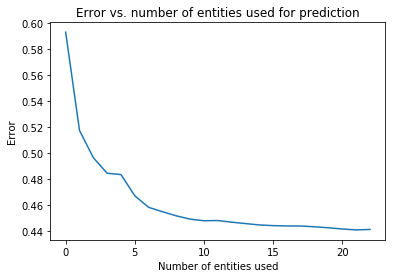

In [10]:
crowd01.plot_crowd_error(X_test_red, y_test, rmse)

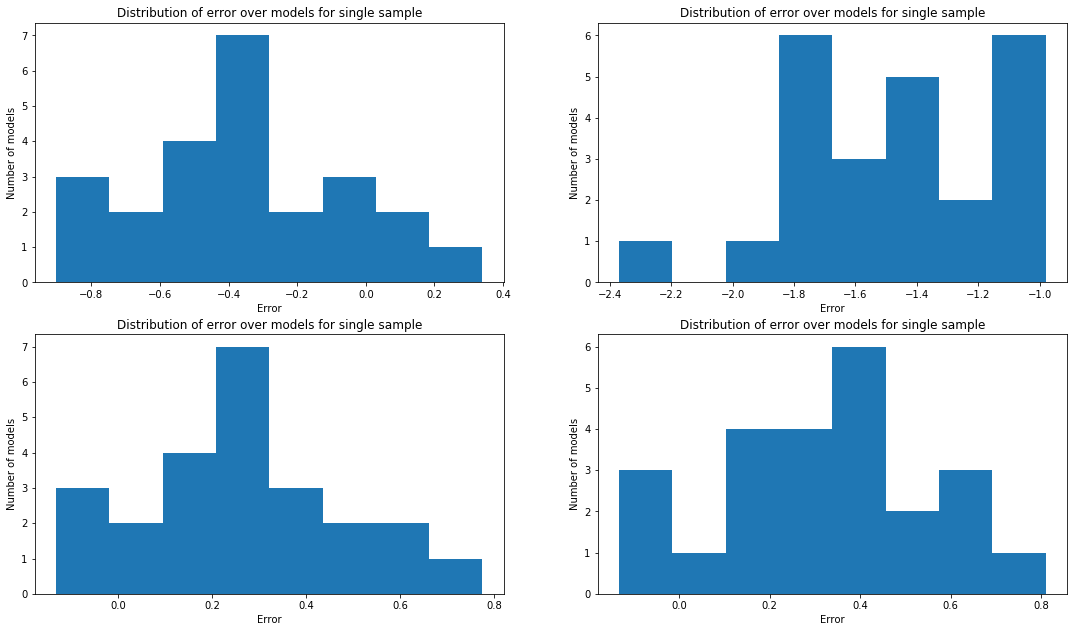

In [11]:
nb_bins = 8

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.subplot(221)
crowd01.plot_error_dist_on_sample(X_test_red[0], y_test[0], basic_error, show = False, bins = nb_bins)
plt.subplot(222)
crowd01.plot_error_dist_on_sample(X_test_red[1], y_test[1], basic_error, show = False, bins = nb_bins)
plt.subplot(223)
crowd01.plot_error_dist_on_sample(X_test_red[2], y_test[2], basic_error, show = False, bins = nb_bins)
plt.subplot(224)
crowd01.plot_error_dist_on_sample(X_test_red[3], y_test[3], basic_error, show = False, bins = nb_bins)
plt.show()

In [12]:
rmse(crowd01.predict(X_test_red), y_test)

0.44112549351712965

In [9]:
crowd02 = crowd.Crowd(X_train_red, y_train, "Crowd02", nb_layers = 16, nb_neurons=64)
crowd02.restore()

Recovered 8 entities from session/Crowd02_16_64_relu_0.01_0.001_mse/8


In [15]:
crowd02.train_new_entities(8)

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20192/20282 [============================>.] - ETA: 0s - loss: 33.5640 - mean_absolute_error: 2.9060
Epoch 00001: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 8s 404us/step - loss: 33.4502 - mean_absolute_error: 2.8979 - val_loss: 8.0761 - val_mean_absolute_error: 1.1117
Epoch 2/200
20256/20282 [============================>.] - ETA: 0s - loss: 6.6572 - mean_absolute_error: 0.8061
Epoch 00002: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 203us/step - loss: 6.6557 - mean_absolute_error: 0.8058 - val_loss: 6.5345 - val_mean_absolute_error: 0.9138
Epoch 3/200
20064/20282 [============================>.] - ETA: 0s - loss: 5.3287 - mean_absolute_error: 0.5496
Epoch 00003: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 199us/step - loss: 5.3263 

Epoch 25/200
20032/20282 [============================>.] - ETA: 0s - loss: 1.0055 - mean_absolute_error: 0.4627
Epoch 00025: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 202us/step - loss: 1.0065 - mean_absolute_error: 0.4634 - val_loss: 1.2804 - val_mean_absolute_error: 0.6241
Epoch 26/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.9561 - mean_absolute_error: 0.4497
Epoch 00026: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 194us/step - loss: 0.9565 - mean_absolute_error: 0.4497 - val_loss: 1.3594 - val_mean_absolute_error: 0.6943
Epoch 27/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.9845 - mean_absolute_error: 0.4732
Epoch 00027: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 211us/step - loss: 0.9856 - mean_absolute_error: 0.4735 - val_loss: 1.1484

Epoch 49/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.7651 - mean_absolute_error: 0.4493
Epoch 00049: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 191us/step - loss: 0.7645 - mean_absolute_error: 0.4488 - val_loss: 0.7786 - val_mean_absolute_error: 0.4346
Epoch 50/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6917 - mean_absolute_error: 0.4036
Epoch 00050: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 196us/step - loss: 0.6924 - mean_absolute_error: 0.4039 - val_loss: 0.8114 - val_mean_absolute_error: 0.4509
Epoch 51/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7598 - mean_absolute_error: 0.4450
Epoch 00051: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 190us/step - loss: 0.7599 - mean_absolute_error: 0.4451 - val_loss: 0.8477

Epoch 73/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6686 - mean_absolute_error: 0.4123
Epoch 00073: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 194us/step - loss: 0.6688 - mean_absolute_error: 0.4124 - val_loss: 0.8928 - val_mean_absolute_error: 0.5662
Epoch 74/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6560 - mean_absolute_error: 0.4003
Epoch 00074: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 192us/step - loss: 0.6561 - mean_absolute_error: 0.4003 - val_loss: 0.7723 - val_mean_absolute_error: 0.4514
Epoch 75/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6458 - mean_absolute_error: 0.3916
Epoch 00075: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 209us/step - loss: 0.6463 - mean_absolute_error: 0.3921 - val_loss: 0.7729

Epoch 97/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6170 - mean_absolute_error: 0.3881
Epoch 00097: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 191us/step - loss: 0.6177 - mean_absolute_error: 0.3887 - val_loss: 0.7709 - val_mean_absolute_error: 0.4478
Epoch 98/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6386 - mean_absolute_error: 0.4027
Epoch 00098: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 194us/step - loss: 0.6388 - mean_absolute_error: 0.4030 - val_loss: 0.7600 - val_mean_absolute_error: 0.4630
Epoch 99/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6269 - mean_absolute_error: 0.3942
Epoch 00099: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 194us/step - loss: 0.6271 - mean_absolute_error: 0.3943 - val_loss: 0.8830

Epoch 121/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6117 - mean_absolute_error: 0.3874
Epoch 00121: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 196us/step - loss: 0.6126 - mean_absolute_error: 0.3880 - val_loss: 0.7450 - val_mean_absolute_error: 0.4565
Epoch 122/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.6154 - mean_absolute_error: 0.3963
Epoch 00122: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 196us/step - loss: 0.6160 - mean_absolute_error: 0.3968 - val_loss: 0.7950 - val_mean_absolute_error: 0.4989
Epoch 123/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6068 - mean_absolute_error: 0.3895
Epoch 00123: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 198us/step - loss: 0.6065 - mean_absolute_error: 0.3893 - val_loss: 0.7

Epoch 145/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.6188 - mean_absolute_error: 0.3954
Epoch 00145: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 182us/step - loss: 0.6185 - mean_absolute_error: 0.3954 - val_loss: 0.6922 - val_mean_absolute_error: 0.4278
Epoch 146/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5891 - mean_absolute_error: 0.3783
Epoch 00146: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 3s 172us/step - loss: 0.5888 - mean_absolute_error: 0.3781 - val_loss: 0.7028 - val_mean_absolute_error: 0.4329
Epoch 147/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.5916 - mean_absolute_error: 0.3829
Epoch 00147: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 173us/step - loss: 0.5919 - mean_absolute_error: 0.3828 - val_loss: 0.7

Epoch 169/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.5775 - mean_absolute_error: 0.3741
Epoch 00169: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 178us/step - loss: 0.5776 - mean_absolute_error: 0.3741 - val_loss: 0.6644 - val_mean_absolute_error: 0.4111
Epoch 170/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.6003 - mean_absolute_error: 0.3897
Epoch 00170: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 180us/step - loss: 0.6006 - mean_absolute_error: 0.3902 - val_loss: 0.7723 - val_mean_absolute_error: 0.4950
Epoch 171/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5892 - mean_absolute_error: 0.3834
Epoch 00171: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 199us/step - loss: 0.5894 - mean_absolute_error: 0.3837 - val_loss: 0.6

Epoch 20/200
20000/20282 [============================>.] - ETA: 0s - loss: 1.3402 - mean_absolute_error: 0.4921
Epoch 00020: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 186us/step - loss: 1.3414 - mean_absolute_error: 0.4921 - val_loss: 1.4472 - val_mean_absolute_error: 0.5176
Epoch 21/200
20160/20282 [============================>.] - ETA: 0s - loss: 1.3992 - mean_absolute_error: 0.5147
Epoch 00021: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 186us/step - loss: 1.3995 - mean_absolute_error: 0.5147 - val_loss: 1.4533 - val_mean_absolute_error: 0.5349
Epoch 22/200
20096/20282 [============================>.] - ETA: 0s - loss: 1.2277 - mean_absolute_error: 0.4754
Epoch 00022: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 183us/step - loss: 1.2266 - mean_absolute_error: 0.4748 - val_loss: 1.2674

Epoch 44/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.7904 - mean_absolute_error: 0.4316
Epoch 00044: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 190us/step - loss: 0.7903 - mean_absolute_error: 0.4315 - val_loss: 0.9481 - val_mean_absolute_error: 0.5203
Epoch 45/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.7746 - mean_absolute_error: 0.4312
Epoch 00045: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 188us/step - loss: 0.7749 - mean_absolute_error: 0.4314 - val_loss: 0.9216 - val_mean_absolute_error: 0.4834
Epoch 46/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.7901 - mean_absolute_error: 0.4350
Epoch 00046: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 178us/step - loss: 0.7937 - mean_absolute_error: 0.4373 - val_loss: 1.1531

Epoch 68/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6969 - mean_absolute_error: 0.4139
Epoch 00068: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 200us/step - loss: 0.6974 - mean_absolute_error: 0.4143 - val_loss: 0.9426 - val_mean_absolute_error: 0.5646
Epoch 69/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6719 - mean_absolute_error: 0.4028
Epoch 00069: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 188us/step - loss: 0.6721 - mean_absolute_error: 0.4030 - val_loss: 0.9891 - val_mean_absolute_error: 0.6293
Epoch 70/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6864 - mean_absolute_error: 0.4199
Epoch 00070: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 192us/step - loss: 0.6876 - mean_absolute_error: 0.4206 - val_loss: 0.9754

Epoch 92/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6509 - mean_absolute_error: 0.4023
Epoch 00092: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 181us/step - loss: 0.6521 - mean_absolute_error: 0.4031 - val_loss: 0.9448 - val_mean_absolute_error: 0.5692
Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20032/20282 [============================>.] - ETA: 0s - loss: 37.2664 - mean_absolute_error: 3.1640
Epoch 00001: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 9s 435us/step - loss: 36.9104 - mean_absolute_error: 3.1399 - val_loss: 7.9441 - val_mean_absolute_error: 1.1907
Epoch 2/200
20224/20282 [============================>.] - ETA: 0s - loss: 6.3155 - mean_absolute_error: 0.8329
Epoch 00002: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 196us/step - loss: 6.3132

Epoch 24/200
20192/20282 [============================>.] - ETA: 0s - loss: 1.0212 - mean_absolute_error: 0.4758
Epoch 00024: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 199us/step - loss: 1.0215 - mean_absolute_error: 0.4762 - val_loss: 1.2107 - val_mean_absolute_error: 0.5994
Epoch 25/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.9277 - mean_absolute_error: 0.4463
Epoch 00025: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 193us/step - loss: 0.9273 - mean_absolute_error: 0.4460 - val_loss: 0.9422 - val_mean_absolute_error: 0.4499
Epoch 26/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.9071 - mean_absolute_error: 0.4449
Epoch 00026: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 191us/step - loss: 0.9070 - mean_absolute_error: 0.4448 - val_loss: 1.1419

Epoch 48/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7175 - mean_absolute_error: 0.4179
Epoch 00048: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 203us/step - loss: 0.7196 - mean_absolute_error: 0.4194 - val_loss: 1.1940 - val_mean_absolute_error: 0.7119
Epoch 49/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.6923 - mean_absolute_error: 0.4020
Epoch 00049: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 198us/step - loss: 0.6939 - mean_absolute_error: 0.4032 - val_loss: 0.9222 - val_mean_absolute_error: 0.5494
Epoch 50/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.7234 - mean_absolute_error: 0.4213
Epoch 00050: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 199us/step - loss: 0.7246 - mean_absolute_error: 0.4223 - val_loss: 0.8702

Epoch 72/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.6611 - mean_absolute_error: 0.3997
Epoch 00072: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 187us/step - loss: 0.6627 - mean_absolute_error: 0.4008 - val_loss: 0.9053 - val_mean_absolute_error: 0.5573
Epoch 73/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.6792 - mean_absolute_error: 0.4170
Epoch 00073: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 186us/step - loss: 0.6817 - mean_absolute_error: 0.4186 - val_loss: 0.7594 - val_mean_absolute_error: 0.4438
Epoch 74/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6561 - mean_absolute_error: 0.4005
Epoch 00074: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 191us/step - loss: 0.6562 - mean_absolute_error: 0.4006 - val_loss: 0.7295

Epoch 96/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6247 - mean_absolute_error: 0.3915
Epoch 00096: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 189us/step - loss: 0.6249 - mean_absolute_error: 0.3916 - val_loss: 0.7220 - val_mean_absolute_error: 0.4400
Epoch 97/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6437 - mean_absolute_error: 0.3983
Epoch 00097: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 201us/step - loss: 0.6436 - mean_absolute_error: 0.3983 - val_loss: 0.7299 - val_mean_absolute_error: 0.4352
Epoch 98/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6463 - mean_absolute_error: 0.4038
Epoch 00098: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 198us/step - loss: 0.6462 - mean_absolute_error: 0.4037 - val_loss: 0.7274

Epoch 120/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.6164 - mean_absolute_error: 0.3852
Epoch 00120: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 198us/step - loss: 0.6168 - mean_absolute_error: 0.3858 - val_loss: 0.7079 - val_mean_absolute_error: 0.4296
Epoch 121/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6086 - mean_absolute_error: 0.3885
Epoch 00121: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 195us/step - loss: 0.6091 - mean_absolute_error: 0.3886 - val_loss: 0.7167 - val_mean_absolute_error: 0.4406
Epoch 122/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6092 - mean_absolute_error: 0.3882
Epoch 00122: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 202us/step - loss: 0.6094 - mean_absolute_error: 0.3883 - val_loss: 0.8

Epoch 15/200
20032/20282 [============================>.] - ETA: 0s - loss: 1.4715 - mean_absolute_error: 0.5181
Epoch 00015: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 204us/step - loss: 1.4709 - mean_absolute_error: 0.5175 - val_loss: 1.5141 - val_mean_absolute_error: 0.5472
Epoch 16/200
20064/20282 [============================>.] - ETA: 0s - loss: 1.4543 - mean_absolute_error: 0.5411
Epoch 00016: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 203us/step - loss: 1.4547 - mean_absolute_error: 0.5415 - val_loss: 1.4765 - val_mean_absolute_error: 0.5507
Epoch 17/200
20096/20282 [============================>.] - ETA: 0s - loss: 1.3452 - mean_absolute_error: 0.5071
Epoch 00017: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 204us/step - loss: 1.3451 - mean_absolute_error: 0.5066 - val_loss: 1.3807

Epoch 39/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.7732 - mean_absolute_error: 0.4257
Epoch 00039: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 199us/step - loss: 0.7746 - mean_absolute_error: 0.4265 - val_loss: 0.8372 - val_mean_absolute_error: 0.4463
Epoch 40/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7407 - mean_absolute_error: 0.4179
Epoch 00040: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 203us/step - loss: 0.7413 - mean_absolute_error: 0.4183 - val_loss: 0.9763 - val_mean_absolute_error: 0.5654
Epoch 41/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.7333 - mean_absolute_error: 0.4135
Epoch 00041: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 206us/step - loss: 0.7333 - mean_absolute_error: 0.4135 - val_loss: 1.0410

Epoch 63/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.6833 - mean_absolute_error: 0.4186
Epoch 00063: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 197us/step - loss: 0.6838 - mean_absolute_error: 0.4192 - val_loss: 0.7915 - val_mean_absolute_error: 0.4745
Epoch 64/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6710 - mean_absolute_error: 0.4134
Epoch 00064: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 198us/step - loss: 0.6706 - mean_absolute_error: 0.4131 - val_loss: 0.7772 - val_mean_absolute_error: 0.4686
Epoch 65/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6756 - mean_absolute_error: 0.4083
Epoch 00065: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 199us/step - loss: 0.6758 - mean_absolute_error: 0.4083 - val_loss: 0.7741

Epoch 87/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6461 - mean_absolute_error: 0.4023
Epoch 00087: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 196us/step - loss: 0.6461 - mean_absolute_error: 0.4024 - val_loss: 0.7331 - val_mean_absolute_error: 0.4475
Epoch 88/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6377 - mean_absolute_error: 0.4024
Epoch 00088: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 201us/step - loss: 0.6376 - mean_absolute_error: 0.4024 - val_loss: 0.8193 - val_mean_absolute_error: 0.5030
Epoch 89/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6363 - mean_absolute_error: 0.4009
Epoch 00089: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 196us/step - loss: 0.6363 - mean_absolute_error: 0.4009 - val_loss: 0.8060

Epoch 12/200
20224/20282 [============================>.] - ETA: 0s - loss: 1.8853 - mean_absolute_error: 0.5143
Epoch 00012: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 218us/step - loss: 1.8847 - mean_absolute_error: 0.5141 - val_loss: 1.9161 - val_mean_absolute_error: 0.5583
Epoch 13/200
20096/20282 [============================>.] - ETA: 0s - loss: 1.7899 - mean_absolute_error: 0.5459
Epoch 00013: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 213us/step - loss: 1.7901 - mean_absolute_error: 0.5464 - val_loss: 2.0401 - val_mean_absolute_error: 0.6972
Epoch 14/200
20192/20282 [============================>.] - ETA: 0s - loss: 1.6690 - mean_absolute_error: 0.5356
Epoch 00014: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 216us/step - loss: 1.6682 - mean_absolute_error: 0.5352 - val_loss: 1.6637

Epoch 36/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.8437 - mean_absolute_error: 0.4433
Epoch 00036: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 214us/step - loss: 0.8432 - mean_absolute_error: 0.4431 - val_loss: 0.9190 - val_mean_absolute_error: 0.4807
Epoch 37/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.8392 - mean_absolute_error: 0.4452
Epoch 00037: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 215us/step - loss: 0.8392 - mean_absolute_error: 0.4452 - val_loss: 0.9481 - val_mean_absolute_error: 0.4935
Epoch 38/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7922 - mean_absolute_error: 0.4211
Epoch 00038: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 217us/step - loss: 0.7949 - mean_absolute_error: 0.4227 - val_loss: 0.9723

Epoch 60/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.7493 - mean_absolute_error: 0.4496
Epoch 00060: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 208us/step - loss: 0.7492 - mean_absolute_error: 0.4496 - val_loss: 0.8307 - val_mean_absolute_error: 0.4791
Epoch 61/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.7095 - mean_absolute_error: 0.4162
Epoch 00061: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 208us/step - loss: 0.7096 - mean_absolute_error: 0.4163 - val_loss: 0.7962 - val_mean_absolute_error: 0.4615
Epoch 62/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6866 - mean_absolute_error: 0.4047
Epoch 00062: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 209us/step - loss: 0.6867 - mean_absolute_error: 0.4047 - val_loss: 0.8433

Epoch 84/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6512 - mean_absolute_error: 0.4005
Epoch 00084: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 206us/step - loss: 0.6511 - mean_absolute_error: 0.4004 - val_loss: 0.7270 - val_mean_absolute_error: 0.4200
Epoch 85/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.6553 - mean_absolute_error: 0.4020
Epoch 00085: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 203us/step - loss: 0.6560 - mean_absolute_error: 0.4021 - val_loss: 0.7298 - val_mean_absolute_error: 0.4268
Epoch 86/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6803 - mean_absolute_error: 0.4213
Epoch 00086: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 206us/step - loss: 0.6805 - mean_absolute_error: 0.4215 - val_loss: 1.0240

Epoch 108/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6474 - mean_absolute_error: 0.4082
Epoch 00108: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 205us/step - loss: 0.6475 - mean_absolute_error: 0.4082 - val_loss: 0.8929 - val_mean_absolute_error: 0.5420
Epoch 109/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6492 - mean_absolute_error: 0.4009
Epoch 00109: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 212us/step - loss: 0.6495 - mean_absolute_error: 0.4014 - val_loss: 0.8650 - val_mean_absolute_error: 0.5326
Epoch 110/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6370 - mean_absolute_error: 0.4040
Epoch 00110: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 218us/step - loss: 0.6374 - mean_absolute_error: 0.4044 - val_loss: 0.8

Epoch 18/200
20000/20282 [============================>.] - ETA: 0s - loss: 1.2204 - mean_absolute_error: 0.4892
Epoch 00018: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 216us/step - loss: 1.2219 - mean_absolute_error: 0.4902 - val_loss: 1.2957 - val_mean_absolute_error: 0.5292
Epoch 19/200
20224/20282 [============================>.] - ETA: 0s - loss: 1.2064 - mean_absolute_error: 0.4984
Epoch 00019: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 213us/step - loss: 1.2062 - mean_absolute_error: 0.4985 - val_loss: 1.2795 - val_mean_absolute_error: 0.5552
Epoch 20/200
20064/20282 [============================>.] - ETA: 0s - loss: 1.0864 - mean_absolute_error: 0.4679
Epoch 00020: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 213us/step - loss: 1.0881 - mean_absolute_error: 0.4684 - val_loss: 1.3239

Epoch 42/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.7466 - mean_absolute_error: 0.4341
Epoch 00042: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 221us/step - loss: 0.7458 - mean_absolute_error: 0.4335 - val_loss: 0.8445 - val_mean_absolute_error: 0.4714
Epoch 43/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.7196 - mean_absolute_error: 0.4208
Epoch 00043: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 5s 225us/step - loss: 0.7194 - mean_absolute_error: 0.4207 - val_loss: 0.8251 - val_mean_absolute_error: 0.4582
Epoch 44/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.7291 - mean_absolute_error: 0.4268
Epoch 00044: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 220us/step - loss: 0.7289 - mean_absolute_error: 0.4267 - val_loss: 0.8347

Epoch 66/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6542 - mean_absolute_error: 0.4085
Epoch 00066: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 217us/step - loss: 0.6544 - mean_absolute_error: 0.4085 - val_loss: 0.8549 - val_mean_absolute_error: 0.5249
Epoch 67/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6747 - mean_absolute_error: 0.4215
Epoch 00067: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 216us/step - loss: 0.6747 - mean_absolute_error: 0.4215 - val_loss: 0.7715 - val_mean_absolute_error: 0.4628
Epoch 68/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.6732 - mean_absolute_error: 0.4190
Epoch 00068: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 217us/step - loss: 0.6752 - mean_absolute_error: 0.4204 - val_loss: 0.8733

Epoch 90/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.6326 - mean_absolute_error: 0.3981
Epoch 00090: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 217us/step - loss: 0.6329 - mean_absolute_error: 0.3983 - val_loss: 0.7395 - val_mean_absolute_error: 0.4359
Epoch 91/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6216 - mean_absolute_error: 0.3919
Epoch 00091: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 222us/step - loss: 0.6210 - mean_absolute_error: 0.3916 - val_loss: 0.7422 - val_mean_absolute_error: 0.4466
Epoch 92/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.6372 - mean_absolute_error: 0.4059
Epoch 00092: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 5s 222us/step - loss: 0.6373 - mean_absolute_error: 0.4061 - val_loss: 0.7294

Epoch 114/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6282 - mean_absolute_error: 0.4028
Epoch 00114: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 216us/step - loss: 0.6283 - mean_absolute_error: 0.4029 - val_loss: 0.7665 - val_mean_absolute_error: 0.4687
Epoch 115/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6528 - mean_absolute_error: 0.4205
Epoch 00115: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 5s 222us/step - loss: 0.6530 - mean_absolute_error: 0.4206 - val_loss: 0.8145 - val_mean_absolute_error: 0.5031
Epoch 116/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.6296 - mean_absolute_error: 0.4028
Epoch 00116: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 5s 224us/step - loss: 0.6295 - mean_absolute_error: 0.4025 - val_loss: 0.7

Epoch 17/200
20032/20282 [============================>.] - ETA: 0s - loss: 1.3456 - mean_absolute_error: 0.4981
Epoch 00017: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 233us/step - loss: 1.3457 - mean_absolute_error: 0.4981 - val_loss: 1.5705 - val_mean_absolute_error: 0.6340
Epoch 18/200
20160/20282 [============================>.] - ETA: 0s - loss: 1.3102 - mean_absolute_error: 0.5123
Epoch 00018: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 238us/step - loss: 1.3098 - mean_absolute_error: 0.5123 - val_loss: 1.3049 - val_mean_absolute_error: 0.4994
Epoch 19/200
20096/20282 [============================>.] - ETA: 0s - loss: 1.2289 - mean_absolute_error: 0.4865
Epoch 00019: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 236us/step - loss: 1.2291 - mean_absolute_error: 0.4865 - val_loss: 1.2565

Epoch 41/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.7236 - mean_absolute_error: 0.4138
Epoch 00041: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 239us/step - loss: 0.7235 - mean_absolute_error: 0.4138 - val_loss: 0.9204 - val_mean_absolute_error: 0.5178
Epoch 42/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7519 - mean_absolute_error: 0.4358
Epoch 00042: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 241us/step - loss: 0.7523 - mean_absolute_error: 0.4362 - val_loss: 0.8178 - val_mean_absolute_error: 0.4573
Epoch 43/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.7353 - mean_absolute_error: 0.4224
Epoch 00043: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 244us/step - loss: 0.7353 - mean_absolute_error: 0.4223 - val_loss: 0.8308

Epoch 65/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6630 - mean_absolute_error: 0.4087
Epoch 00065: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 244us/step - loss: 0.6634 - mean_absolute_error: 0.4090 - val_loss: 0.7678 - val_mean_absolute_error: 0.4544
Epoch 66/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6534 - mean_absolute_error: 0.4026
Epoch 00066: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 250us/step - loss: 0.6544 - mean_absolute_error: 0.4035 - val_loss: 0.8198 - val_mean_absolute_error: 0.5126
Epoch 67/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6608 - mean_absolute_error: 0.4074
Epoch 00067: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 252us/step - loss: 0.6610 - mean_absolute_error: 0.4076 - val_loss: 0.7672

Epoch 89/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6515 - mean_absolute_error: 0.4080
Epoch 00089: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 251us/step - loss: 0.6515 - mean_absolute_error: 0.4081 - val_loss: 0.7356 - val_mean_absolute_error: 0.4362
Epoch 90/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6231 - mean_absolute_error: 0.3918
Epoch 00090: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 251us/step - loss: 0.6235 - mean_absolute_error: 0.3923 - val_loss: 0.7259 - val_mean_absolute_error: 0.4440
Epoch 91/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6248 - mean_absolute_error: 0.3974
Epoch 00091: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 256us/step - loss: 0.6257 - mean_absolute_error: 0.3976 - val_loss: 0.7762

Epoch 113/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6281 - mean_absolute_error: 0.4020
Epoch 00113: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 241us/step - loss: 0.6278 - mean_absolute_error: 0.4018 - val_loss: 0.7463 - val_mean_absolute_error: 0.4527
Epoch 114/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6458 - mean_absolute_error: 0.4124
Epoch 00114: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 245us/step - loss: 0.6458 - mean_absolute_error: 0.4119 - val_loss: 0.7710 - val_mean_absolute_error: 0.4826
Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20160/20282 [============================>.] - ETA: 0s - loss: 34.9985 - mean_absolute_error: 3.0931
Epoch 00001: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 12s 590us/step - loss: 34.

Epoch 23/200
20160/20282 [============================>.] - ETA: 0s - loss: 1.0555 - mean_absolute_error: 0.4672
Epoch 00023: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 262us/step - loss: 1.0564 - mean_absolute_error: 0.4677 - val_loss: 1.2864 - val_mean_absolute_error: 0.6022
Epoch 24/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.9885 - mean_absolute_error: 0.4483
Epoch 00024: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 255us/step - loss: 0.9900 - mean_absolute_error: 0.4491 - val_loss: 1.2817 - val_mean_absolute_error: 0.5947
Epoch 25/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.9873 - mean_absolute_error: 0.4525
Epoch 00025: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 249us/step - loss: 0.9882 - mean_absolute_error: 0.4532 - val_loss: 1.1354

Epoch 47/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.7007 - mean_absolute_error: 0.4137
Epoch 00047: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 247us/step - loss: 0.7010 - mean_absolute_error: 0.4139 - val_loss: 0.8660 - val_mean_absolute_error: 0.4832
Epoch 48/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.7181 - mean_absolute_error: 0.4225
Epoch 00048: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 249us/step - loss: 0.7183 - mean_absolute_error: 0.4228 - val_loss: 0.7930 - val_mean_absolute_error: 0.4458
Epoch 49/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.7064 - mean_absolute_error: 0.4205
Epoch 00049: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 251us/step - loss: 0.7070 - mean_absolute_error: 0.4209 - val_loss: 0.8110

Epoch 71/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6648 - mean_absolute_error: 0.4091
Epoch 00071: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 251us/step - loss: 0.6647 - mean_absolute_error: 0.4090 - val_loss: 0.7668 - val_mean_absolute_error: 0.4390
Epoch 72/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6411 - mean_absolute_error: 0.3933
Epoch 00072: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 247us/step - loss: 0.6412 - mean_absolute_error: 0.3934 - val_loss: 0.7631 - val_mean_absolute_error: 0.4435
Epoch 73/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6365 - mean_absolute_error: 0.3996
Epoch 00073: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 250us/step - loss: 0.6364 - mean_absolute_error: 0.3995 - val_loss: 0.7177

Epoch 95/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6142 - mean_absolute_error: 0.3908
Epoch 00095: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 254us/step - loss: 0.6143 - mean_absolute_error: 0.3908 - val_loss: 0.7448 - val_mean_absolute_error: 0.4626
Epoch 96/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.6152 - mean_absolute_error: 0.3933
Epoch 00096: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 251us/step - loss: 0.6159 - mean_absolute_error: 0.3939 - val_loss: 0.7749 - val_mean_absolute_error: 0.4903
Epoch 97/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6068 - mean_absolute_error: 0.3878
Epoch 00097: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 252us/step - loss: 0.6074 - mean_absolute_error: 0.3881 - val_loss: 0.8623

Epoch 119/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6101 - mean_absolute_error: 0.3945
Epoch 00119: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 253us/step - loss: 0.6101 - mean_absolute_error: 0.3945 - val_loss: 0.7411 - val_mean_absolute_error: 0.4888
Epoch 120/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6078 - mean_absolute_error: 0.3985
Epoch 00120: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 252us/step - loss: 0.6077 - mean_absolute_error: 0.3985 - val_loss: 0.6850 - val_mean_absolute_error: 0.4346
Epoch 121/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6000 - mean_absolute_error: 0.3928
Epoch 00121: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 251us/step - loss: 0.6000 - mean_absolute_error: 0.3929 - val_loss: 0.7

Epoch 143/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5947 - mean_absolute_error: 0.3927
Epoch 00143: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 252us/step - loss: 0.5945 - mean_absolute_error: 0.3926 - val_loss: 0.7839 - val_mean_absolute_error: 0.5038
Epoch 144/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5977 - mean_absolute_error: 0.3918
Epoch 00144: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 6s 280us/step - loss: 0.5981 - mean_absolute_error: 0.3922 - val_loss: 0.7577 - val_mean_absolute_error: 0.4794
Epoch 145/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5845 - mean_absolute_error: 0.3843
Epoch 00145: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 259us/step - loss: 0.5852 - mean_absolute_error: 0.3849 - val_loss: 0.8

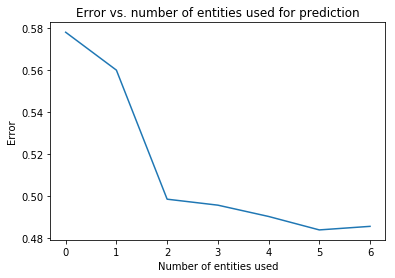

In [16]:
crowd02.plot_crowd_error(X_test_red, y_test, rmse)

In [17]:
rmse(crowd02.predict(X_test_red), y_test)

0.4681255154422219

In [10]:
supercrowd = sc.SuperCrowd()
supercrowd.append_crowd(crowd01)
supercrowd.append_crowd(crowd02)

In [15]:
rmse(supercrowd.predict(X_test_red), y_test)

0.4466822622047349

## Results
The results are good, however we remark a bias which has to be corrected using other networks in the crowd (of other type maybe).

# Mixture of experts

In [8]:
experts01 = experts.Experts(X_train_red, y_train, "Expert01")
experts01.restore()

Recovered 32 entities from session/Expert01_8_128_relu_0.01_0.001_mse/32


In [ ]:
experts01.train_new_entities(8)

In [9]:
experts01.predict(X_test_red)

####################
# Creating gatingnet #
####################
Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20096/20282 [============================>.] - ETA: 0s - loss: 3.5596 - acc: 0.0318
Epoch 00001: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/gatingnet
20282/20282 [==============================] - 7s 330us/step - loss: 3.5595 - acc: 0.0318 - val_loss: 3.5471 - val_acc: 0.0346
Epoch 2/200
20224/20282 [============================>.] - ETA: 0s - loss: 3.5267 - acc: 0.0376
Epoch 00002: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/gatingnet
20282/20282 [==============================] - 4s 190us/step - loss: 3.5267 - acc: 0.0377 - val_loss: 3.5322 - val_acc: 0.0306
Epoch 3/200
20160/20282 [============================>.] - ETA: 0s - loss: 3.5094 - acc: 0.0398
Epoch 00003: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/gatingnet
20282/20282 [==============================] - 4s 188us/step - loss: 3.5094 - acc: 0.0398 - val_lo

Epoch 28/200
20064/20282 [============================>.] - ETA: 0s - loss: 2.6983 - acc: 0.2958
Epoch 00028: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/gatingnet
20282/20282 [==============================] - 4s 183us/step - loss: 2.6973 - acc: 0.2960 - val_loss: 5.9440 - val_acc: 0.0475
Epoch 29/200
20160/20282 [============================>.] - ETA: 0s - loss: 2.6695 - acc: 0.3092
Epoch 00029: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/gatingnet
20282/20282 [==============================] - 4s 185us/step - loss: 2.6695 - acc: 0.3090 - val_loss: 6.3426 - val_acc: 0.0413
Epoch 30/200
20096/20282 [============================>.] - ETA: 0s - loss: 2.6453 - acc: 0.3185
Epoch 00030: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/gatingnet
20282/20282 [==============================] - 4s 188us/step - loss: 2.6458 - acc: 0.3180 - val_loss: 6.2503 - val_acc: 0.0435
Epoch 31/200
20000/20282 [============================>.] - ETA: 0s - loss: 2.6249

array([30.62523771, 33.19525126, 30.06397751, ..., 30.96571565,
       27.6651332 , 27.85913135])

In [10]:
rmse(experts01.predict(X_test_red), y_test), rmse(experts01.predict(X_train_red), y_train)

(0.4400113089914007, 0.2719218974460002)

## Conversion from vectors to images
This part is dedicated to test if vectors can be easily classified. This is important to know since the gateway we are running tries to classify the vectors in categories (represented by the brain that makes the best final prediction).

Then we transfrom our vectors into images, and we display several images for each brains, hoping that the images of one brain will be distinguishables from another. This would confort us in the idea that vectors are easily classifiable.

In [22]:
def to_image(sample, size):
    img = np.zeros((54, 54))
    max_ = max(sample)
    min_ = min(sample)
    for i, s in enumerate(sample):
        if i >= 54**2:
            break
        img[i // 54][i % 54] = (s - min_)/(max_ - min_)*255
    im = Image.fromarray(img)
    im = im.resize((size,size), Image.ANTIALIAS)
    im.show()

In [46]:
gateway_matrix = experts01.get_gateway_matrix()
BRAIN_NB = 3
brain_samples = []
for i, g in enumerate(gateway_matrix):
    if g == BRAIN_NB:
        brain_samples.append(X_train_red[i])
        
print(len(brain_samples))

599


In [45]:
for b in brain_samples[:3]:
    to_image(b, 256)

## Conclusion on image conversion

After comparing the images of several brain, we concluded that they are not very different from each others, we can hardly detect patterns that appear in one set of images and not in another. This result suggests that our vectors are not classifiable. 

Was is certain is that they are not diffentiable enough for basic classification algorithms (e.g the ones used in image classification) to classify them efficiently, which goes in the same sens than our experiences so far.

# Trying Dropout layers
Dropout layers have been reported in the litterature to bring good results to avoid overfitting in combination with L2 regularizers http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf (Srivastava et al.). It will train the model while keeping only a neuron active with probability p.

In [12]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Assuming each layer represent a link between particules, we begin with 4 layers
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

TypeError: dropout() got an unexpected keyword argument 'activation'

In [ ]:
# We train the model on our data
# Number of epochs the network should run through
EPOCHS = 100
# Size of the batch for optimization
BATCH_SIZE = 32
# Set up validation split
VALIDATION_SPLIT = 0.2
# The patience parameter is the amount of epochs to check for improvement
# This will avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

In [ ]:
plot_history(history)

#  Feature selection matrix

In [6]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")
X_red.shape

(30049, 3004)

In [7]:
train_set_size = int(len(X_red) * TRAIN_SET_PERC)
X_train_red = X_red[: train_set_size]
X_test_red = X_red[train_set_size:]
y_train = y[: train_set_size]
y_test = y[train_set_size :]

In [8]:
print("X_red: " + str(X_red.shape))
print("y: " + str(y.shape))

X_red: (30049, 3004)
y: (30049,)


In [9]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Number of layers and neurons doesn't really matter, we need as much as possible.
    # We well take care of overfitting with regularizers.
    # We chose relu activation (relative usual choice when working on regression)
    # We add L2 regularizers on hidden layers to avoid overfitting the data. Threshold should be tuned.
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

In [10]:
EPOCHS = 200
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

Train on 24339 samples, validate on 2705 samples
Epoch 1/200
24339/24339 [==============================] - 21s 882us/step - loss: 16.2423 - mean_absolute_error: 2.7712 - val_loss: 11.7952 - val_mean_absolute_error: 2.7973
Epoch 2/200
24339/24339 [==============================] - 20s 823us/step - loss: 2.7857 - mean_absolute_error: 1.0994 - val_loss: 2.2373 - val_mean_absolute_error: 0.9991
Epoch 3/200
24339/24339 [==============================] - 20s 836us/step - loss: 0.8024 - mean_absolute_error: 0.4852 - val_loss: 1.8001 - val_mean_absolute_error: 0.8622
Epoch 4/200
24339/24339 [==============================] - 21s 855us/step - loss: 0.6898 - mean_absolute_error: 0.4331 - val_loss: 1.5499 - val_mean_absolute_error: 0.7983
Epoch 5/200
24339/24339 [==============================] - 20s 808us/step - loss: 0.7234 - mean_absolute_error: 0.4703 - val_loss: 1.5848 - val_mean_absolute_error: 0.8310
Epoch 6/200
24339/24339 [==============================] - 19s 799us/step - loss: 0.7371 

24339/24339 [==============================] - 21s 851us/step - loss: 0.1102 - mean_absolute_error: 0.1804 - val_loss: 0.6129 - val_mean_absolute_error: 0.5024
Epoch 96/200
24339/24339 [==============================] - 20s 839us/step - loss: 0.1113 - mean_absolute_error: 0.1835 - val_loss: 0.6052 - val_mean_absolute_error: 0.4992
Epoch 97/200
24339/24339 [==============================] - 21s 848us/step - loss: 0.1150 - mean_absolute_error: 0.1902 - val_loss: 0.6312 - val_mean_absolute_error: 0.5190
Epoch 98/200
24339/24339 [==============================] - 21s 849us/step - loss: 0.1101 - mean_absolute_error: 0.1823 - val_loss: 0.6291 - val_mean_absolute_error: 0.5101
Epoch 99/200
24339/24339 [==============================] - 21s 849us/step - loss: 0.1202 - mean_absolute_error: 0.1958 - val_loss: 0.6232 - val_mean_absolute_error: 0.5087
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)   

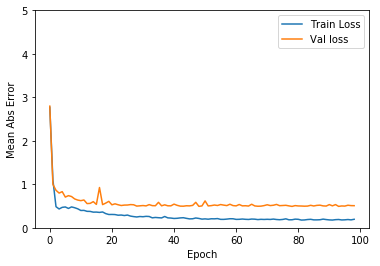

In [11]:
plot_history(history)

In [12]:
result = model.predict(X_test_red, batch_size=32)
rmse(result, y_test)

0.6834309411311952

# Verification of feature selection matrix - polynomial expansion

In [9]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

In [10]:
X_red.shape

(30049, 3004)

In [13]:
X_poly = build_poly(X_red, 2)

In [14]:
X_poly.shape

(30049, 6008)

In [15]:
train_set_size = int(len(X_red) * TRAIN_SET_PERC)
X_poly_train_red = X_poly[: train_set_size]
X_poly_test_red = X_poly[train_set_size:]
y_train = y[: train_set_size]
y_test = y[train_set_size :]

In [16]:
print("X_poly_red: " + str(X_poly.shape))
print("y: " + str(y.shape))

X_poly_red: (30049, 6008)
y: (30049,)


In [18]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Number of layers and neurons doesn't really matter, we need as much as possible.
    # We well take care of overfitting with regularizers.
    # We chose relu activation (relative usual choice when working on regression)
    # We add L2 regularizers on hidden layers to avoid overfitting the data. Threshold should be tuned.
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

In [19]:
EPOCHS = 200
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_poly_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

Train on 24339 samples, validate on 2705 samples
Epoch 1/200
24339/24339 [==============================] - 15s 609us/step - loss: 68.8399 - mean_absolute_error: 5.7557 - val_loss: 27.8898 - val_mean_absolute_error: 3.7220
Epoch 2/200
24339/24339 [==============================] - 12s 498us/step - loss: 6.5372 - mean_absolute_error: 1.8642 - val_loss: 18.6232 - val_mean_absolute_error: 2.6665
Epoch 3/200
24339/24339 [==============================] - 12s 502us/step - loss: 2.9390 - mean_absolute_error: 1.2613 - val_loss: 13.8524 - val_mean_absolute_error: 2.5427
Epoch 4/200
24339/24339 [==============================] - 12s 504us/step - loss: 2.3184 - mean_absolute_error: 1.1061 - val_loss: 16.8185 - val_mean_absolute_error: 2.3774
Epoch 5/200
24339/24339 [==============================] - 12s 508us/step - loss: 2.9168 - mean_absolute_error: 1.1900 - val_loss: 16.8111 - val_mean_absolute_error: 3.0914
Epoch 6/200
24339/24339 [==============================] - 12s 512us/step - loss: 4.4

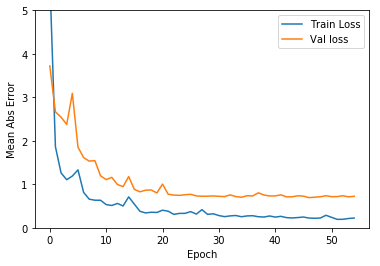

In [20]:
plot_history(history)

In [21]:
result = model.predict(X_poly_test_red, batch_size=32)
rmse(result, y_test)

1.0123385147545783